In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from qtaim_embed.models.utils import load_graph_level_model_from_config
from qtaim_embed.data.dataloader import DataLoaderMoleculeGraphTask
from qtaim_embed.core.dataset import HeteroGraphGraphLabelDataset
from qtaim_embed.models.utils import get_test_train_preds_as_df, test_and_predict


In [2]:
qtaim_keys_high = {
    "atom": [
        "extra_feat_atom_Lagrangian_K",
        "extra_feat_atom_Hamiltonian_K",
        "extra_feat_atom_e_density",
        "extra_feat_atom_lap_e_density",
        "extra_feat_atom_e_loc_func",
        "extra_feat_atom_ave_loc_ion_E",
        "extra_feat_atom_delta_g_promolecular",
        "extra_feat_atom_delta_g_hirsh",
        "extra_feat_atom_esp_nuc",
        "extra_feat_atom_esp_e",
        "extra_feat_atom_esp_total",
        "extra_feat_atom_grad_norm",
        "extra_feat_atom_lap_norm",
        "extra_feat_atom_eig_hess",
        "extra_feat_atom_det_hessian",
        "extra_feat_atom_ellip_e_dens",
        "extra_feat_atom_eta",
        "extra_feat_atom_density_beta",
        "extra_feat_atom_density_alpha",
        "extra_feat_atom_spin_density",
        "extra_feat_atom_lol",
    ],
    "bond": [
        "extra_feat_bond_Lagrangian_K",
        "extra_feat_bond_Hamiltonian_K",
        "extra_feat_bond_e_density",
        "extra_feat_bond_lap_e_density",
        "extra_feat_bond_e_loc_func",
        "extra_feat_bond_ave_loc_ion_E",
        "extra_feat_bond_delta_g_promolecular",
        "extra_feat_bond_delta_g_hirsh",
        "extra_feat_bond_esp_nuc",
        "extra_feat_bond_esp_e",
        "extra_feat_bond_esp_total",
        "extra_feat_bond_grad_norm",
        "extra_feat_bond_lap_norm",
        "extra_feat_bond_eig_hess",
        "extra_feat_bond_det_hessian",
        "extra_feat_bond_ellip_e_dens",
        "extra_feat_bond_eta",
        "extra_feat_bond_energy_density",
        "extra_feat_bond_density_beta",
        "extra_feat_bond_density_alpha",
        "extra_feat_bond_spin_density",
        "extra_feat_bond_lol",
    ],
    "global": ["corrected_E"],
}


libe_loc = "../../../../data/splits_1205/test_qm9_qtaim_1205_labelled_corrected.pkl"
libe_loc_train = (
    "../../../../data/splits_1205/train_qm9_qtaim_1205_labelled_corrected.pkl"
)

base_dict = {
    "atom": [],
    "bond": ["bond_length"],
    "global": ["corrected_E"],
}

dataset_dict = {}
keys_list = [
    #base_dict,
    qtaim_keys_high,
]
for ind, feat_dict in enumerate(keys_list):
    if ind == 0:
        key = "base"
    elif ind == 1:
        key = "qtaim_full"
    key = "qtaim_full"

    dataset_dict[key + "_test"] = HeteroGraphGraphLabelDataset(
        file=libe_loc,
        allowed_ring_size=[4, 5, 6, 7],
        allowed_charges=None,
        allowed_spins=None,
        self_loop=True,
        extra_keys=feat_dict,
        target_list=["corrected_E"],
        extra_dataset_info={},
        debug=False,
        log_scale_features=True,
        log_scale_targets=False,
        standard_scale_features=True,
        standard_scale_targets=True,
    )
    dataset_dict[key + "_train"] = HeteroGraphGraphLabelDataset(
        file=libe_loc_train,
        allowed_ring_size=[4, 5, 6, 7],
        allowed_charges=None,
        allowed_spins=None,
        self_loop=True,
        extra_keys=feat_dict,
        target_list=["corrected_E"],
        extra_dataset_info={},
        debug=False,
        log_scale_features=True,
        log_scale_targets=False,
        standard_scale_features=True,
        standard_scale_targets=True,
    )


In [ ]:
for k, v in dataset_dict.items():
    print(v.feature_size())

{'atom': 32, 'bond': 28, 'global': 3}
{'atom': 32, 'bond': 28, 'global': 3}


In [ ]:
qtaim_model_bl_dict = {
    "atom_feature_size": 33,
    "bond_feature_size": 28,
    "global_feature_size": 3,
    "conv_fn": "ResidualBlock",
    "target_dict": {"global": ["homo", "lumo", "gap"]},
    "dropout": 0.2,
    "batch_norm_tf": True,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 6,
    "lr": 0.01,
    "weight_decay": 5e-05,
    "lr_plateau_patience": 25,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 3,
    "embedding_size": 100,
    "fc_layer_size": [512, 512, 512],
    "shape_fc": "flat",
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 3,
    "global_pooling_fn": "WeightedMeanPoolingThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 15,
    "lstm_layers": 2,
    "num_heads": 2,
    "feat_drop": 0.1,
    "attn_drop": 0.1,
    "residual": True,
    "ntasks": 1,
    "num_heads_gat": 2,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 50,
    "residual_gat": True,
    "shape_fc": "cone",
    "classifier": False,
    "fc_num_layers": 3,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "fc_hidden_size_1": 1024,
    "fc_num_layers": 2,
    "restore": False,
    "classifier": False,
}


non_qtaim_model_bl_dict = {
    "atom_feature_size": 13,
    "bond_feature_size": 8,
    "global_feature_size": 3,
    "conv_fn": "GraphConvDropoutBatch",
    "target_dict": {"global": ["homo", "lumo", "gap"]},
    "dropout": 0.2,
    "batch_norm_tf": True,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "fc_num_layers": 3,
    "aggregate": "sum",
    "n_conv_layers": 6,
    "lr": 0.01885852849843154,
    "weight_decay": 1e-05,
    "lr_plateau_patience": 25,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 2,
    "embedding_size": 50,
    "fc_layer_size": [1024, 512, 256],
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 3,
    "global_pooling_fn": "SumPoolingThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 9,
    "lstm_layers": 2,
    "num_heads": 3,
    "feat_drop": 0.1,
    "attn_drop": 0.1,
    "residual": False,
    "hidden_size": 10,
    "ntasks": 1,
    "shape_fc": "cone",
    "num_heads_gat": 3,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 10,
    "residual_gat": False,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "fc_hidden_size_1": 512,
    "restore": False,
    "classifier": False,
}


model_temp_qtaim = load_graph_level_model_from_config(qtaim_model_bl_dict)
model_temp_noqtaim = load_graph_level_model_from_config(non_qtaim_model_bl_dict)


:::REGRESSION MODEL:::
readout in size 203
... > number of tasks: 3
:::REGRESSION MODEL:::
readout in size 150
... > number of tasks: 3


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_dict["qtaim_full_train"], batch_size=256, shuffle=True, num_workers=4, persistent_workers=True
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_dict["qtaim_full_test"],
    batch_size=len(dataset_dict["qtaim_full_test"].graphs),
    shuffle=False,
    num_workers=0,
)
early_stopping_callback = EarlyStopping(
    monitor="val_mae", min_delta=0.00, patience=200, verbose=False, mode="min"
)
lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    gradient_clip_val=100.0,
    devices=[0],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    callbacks=[
        early_stopping_callback,
        lr_monitor,
    ],
    enable_checkpointing=True,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="bf16-mixed",
)
trainer.fit(model_temp_qtaim, dataloader_train)
trainer.save_checkpoint(f"retrain_qtaim_qm9.ckpt")


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                 | Params
----------------------------------------------------------
0  | activation      | ReLU                 | 0     
1  | embedding       | UnifySize            | 6.3 K 
2  | conv_layers     | ModuleList           | 526 K 
3  | readout         | WeightAndMeanThenCat | 202   
4  | loss            | ModuleList           | 0     
5  | fc_layers       | ModuleList           | 738 K 
6  | train_r2        | MultioutputWrapper   | 0     
7  | train_torch_l1

Training: 0it [00:00, ?it/s]

/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('val_mae', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Epoch 00027: reducing learning rate of group 0 to 5.0000e-03.


In [ ]:
"""dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_dict["qtaim_full_train"], batch_size=1024, shuffle=True, num_workers=0
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_dict["qtaim_full_test"],
    batch_size=len(dataset_dict["qtaim_full_test"].graphs),
    shuffle=False,
    num_workers=0,
)"""

batch_graph, batched_labels = next(iter(dataloader_test))
model_temp_qtaim.cpu()
(
    r2_val, mae_val, mse_val, preds_unscaled, labels_unscaled
) = model_temp_qtaim.evaluate_manually(
    batch_graph=batch_graph,
    batch_label=batched_labels,
    scaler_list=dataset_dict["qtaim_full_train"].label_scalers,
    per_atom=False,
)


NameError: name 'dataloader_test' is not defined

In [ ]:
r2_val  # really good mae!
#tensor([0.9579, 0.9838, 0.9781])
# tensor([0.9633, 0.9857, 0.9808])

tensor([0.9634, 0.9848, 0.9802])

In [ ]:
mae_val 
# tensor([0.0035, 0.0045, 0.0053])
# tensor([0.0032, 0.0042, 0.0049])

In [ ]:
mse_val 
# tensor([0.0045, 0.0060, 0.0070])
# tensor([0.0042, 0.0056, 0.0066])

tensor([0.0042, 0.0058, 0.0067])

/tmp/ipykernel_8633/3368991784.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


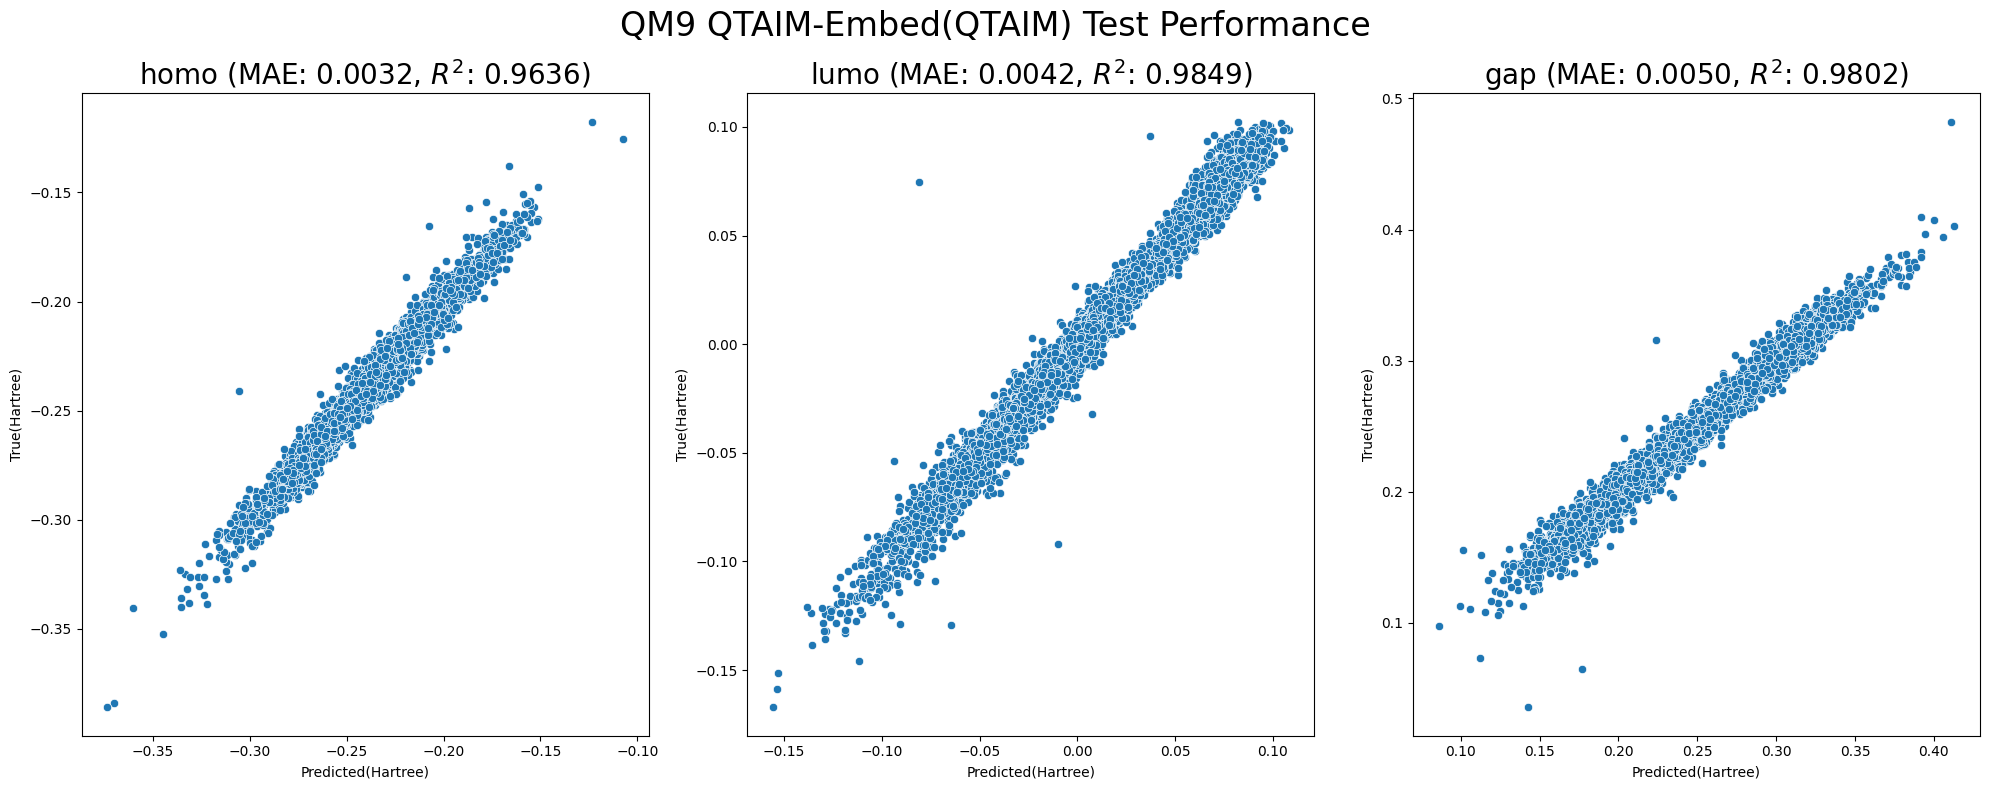

In [43]:
name_list = ["corrected_E"]

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
for i in range(1):
    key = name_list[i]
    sns.scatterplot(x=preds_unscaled[:, i], y=labels_unscaled[:, i], ax=ax[i])
    mae = np.abs(
        preds_unscaled[:, i].detach().numpy() - labels_unscaled[:, i].detach().numpy()
    )
    mae = np.mean(mae)
    r2 = (
        np.corrcoef(np.array(preds_unscaled[:, i]), np.array(labels_unscaled[:, i]))[
            1, 0
        ]
        ** 2
    )

    ax[i].set_title(
        "{} (MAE: {:.4f}, $R^2$: {:.4f})".format(
            key,
            mae,
            r2,
        ), fontsize=20
    )
    ax[i].set_xlabel("Predicted(Hartree)")
    ax[i].set_ylabel("True(Hartree)")
fig.suptitle("QM9 QTAIM-Embed(QTAIM) Test Performance", fontsize=24)
fig.tight_layout()
save_string = os.path.join(
    "./test_performance_{}_{}.png".format("qm9", "qtaim")
)
fig.savefig(save_string, dpi=300)
fig.show()

In [33]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_dict["base_train"], batch_size=1024, shuffle=True, num_workers=0
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_dict["base_test"],
    batch_size=len(dataset_dict["base_test"].graphs),
    shuffle=False,
    num_workers=0,
)
early_stopping_callback = EarlyStopping(
    monitor="val_mae", min_delta=0.00, patience=200, verbose=False, mode="min"
)
lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    gradient_clip_val=100.0,
    devices=1,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    callbacks=[
        early_stopping_callback,
        lr_monitor,
    ],
    enable_checkpointing=True,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="bf16-mixed",
)
trainer.fit(model_temp_noqtaim, dataloader_train)
trainer.save_checkpoint(f"retrain_no_qtaim_qm9.ckpt")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type               | Params
--------------------------------------------------------
0  | activation      | ReLU               | 0     
1  | embedding       | UnifySize          | 1.2 K 
2  | conv_layers     | ModuleList         | 143 K 
3  | readout         | SumPoolingThenCat  | 0     
4  | loss            | ModuleList         | 0     
5  | fc_layers       | ModuleList         | 243 K 
6  | train_r2        | MultioutputWrapper | 0     
7  | train_torch_l1  | MultioutputWrapper | 0     
8  | train_torch_mse | MultioutputWrapper | 0     
9  | val_r2          | MultioutputWrapper | 0     
10 | val_torch_l1    | MultioutputWrapper | 0     
11 | val_torch_mse   | MultioutputWrapper | 0     
12 | test_r2         | MultioutputWr

Training: 0it [00:00, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 9.4293e-03.
Epoch 00053: reducing learning rate of group 0 to 4.7146e-03.
Epoch 00079: reducing learning rate of group 0 to 2.3573e-03.
Epoch 00105: reducing learning rate of group 0 to 1.1787e-03.
Epoch 00131: reducing learning rate of group 0 to 5.8933e-04.
Epoch 00157: reducing learning rate of group 0 to 2.9466e-04.
Epoch 00183: reducing learning rate of group 0 to 1.4733e-04.


In [34]:
batch_graph, batched_labels = next(iter(dataloader_test))
model_temp_noqtaim.cpu()
(
    r2_val, mae_val, mse_val, preds_unscaled, labels_unscaled
) = model_temp_noqtaim.evaluate_manually(
    batch_graph=batch_graph,
    batch_label=batched_labels,
    scaler_list=dataset_dict["base_train"].label_scalers,
    per_atom=False,
)


/tmp/ipykernel_8633/1349792642.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


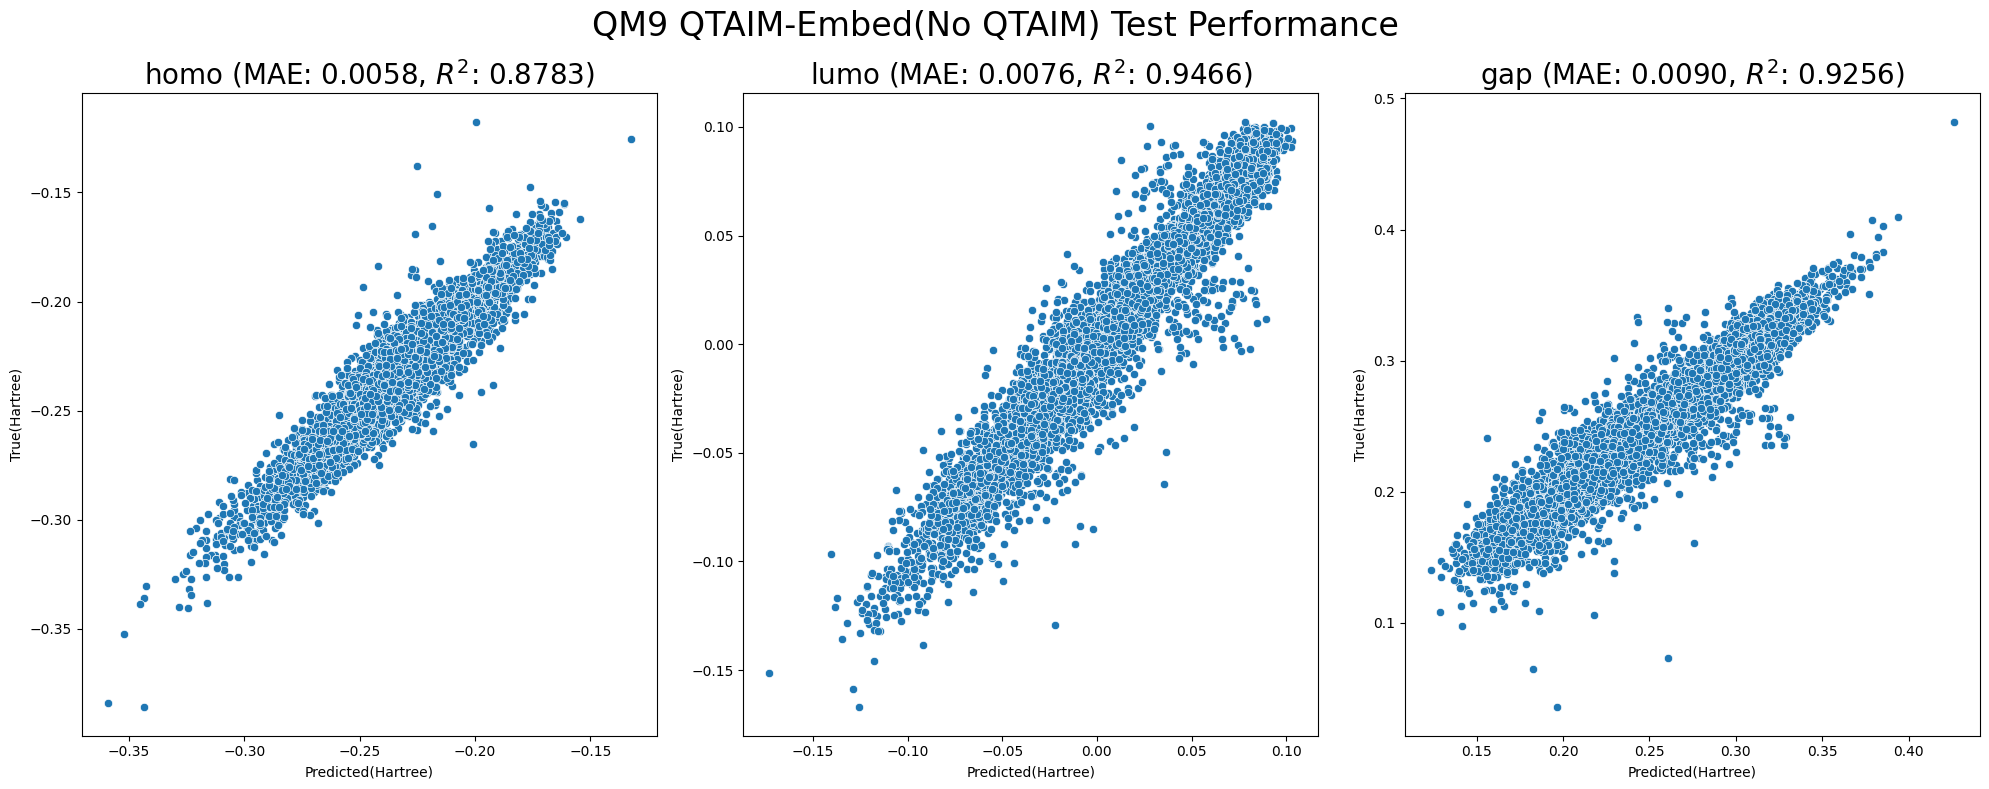

In [37]:
name_list = ["corrected_E"]


fig, ax = plt.subplots(1, 1, figsize=(20, 8))
for i in range(1):
    key = name_list[i]
    sns.scatterplot(x=preds_unscaled[:, i], y=labels_unscaled[:, i], ax=ax[i])
    mae = np.abs(
        preds_unscaled[:, i].detach().numpy() - labels_unscaled[:, i].detach().numpy()
    )
    mae = np.mean(mae)
    r2 = (
        np.corrcoef(np.array(preds_unscaled[:, i]), np.array(labels_unscaled[:, i]))[
            1, 0
        ]
        ** 2
    )

    ax[i].set_title(
        "{} (MAE: {:.4f}, $R^2$: {:.4f})".format(
            key,
            mae,
            r2,
        ),
        fontsize=20
    )
    ax[i].set_xlabel("Predicted(Hartree)")
    ax[i].set_ylabel("True(Hartree)")
fig.suptitle("QM9 QTAIM-Embed(No QTAIM) Test Performance", fontsize=24)
# set suptitle font size 

fig.tight_layout()
save_string = os.path.join(
    "./test_performance_{}_{}.png".format("qm9", "no_qtaim")
)
fig.savefig(save_string, dpi=300)
fig.show()